In [24]:
import os
import shutil
import random
from typing import Dict
import pandas as pd


In [25]:
class DatasetCSVSplitter:
    def __init__(
        self,
        source_dir: str,
        split_ratio: Dict[str, float],
        seed: int = 42
    ):
        self.source_dir = source_dir
        self.split_ratio = split_ratio
        random.seed(seed)

    def split(self):
        records = []

        classes = [
            d for d in os.listdir(self.source_dir)
            if os.path.isdir(os.path.join(self.source_dir, d))
        ]

        for cls in classes:
            cls_path = os.path.join(self.source_dir, cls)
            images = [
                img for img in os.listdir(cls_path)
                if img.lower().endswith((".png", ".jpg", ".jpeg"))
            ]

            random.shuffle(images)
            total = len(images)

            train_end = int(total * self.split_ratio["train"])
            test_end = train_end + int(total * self.split_ratio["test"])

            splits = {
                "train": images[:train_end],
                "test": images[train_end:test_end],
                "eval": images[test_end:]
            }

            for split, imgs in splits.items():
                for img in imgs:
                    records.append({
                        "image_path": os.path.join(cls_path, img),
                        "class": cls,
                        "split": split
                    })

        return pd.DataFrame(records)


In [26]:
SOURCE_DIR = "/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam"

SPLIT_RATIO = {
    "train": 0.7,
    "test": 0.2,
    "eval": 0.1
}

splitter = DatasetCSVSplitter(
    source_dir=SOURCE_DIR,
    split_ratio=SPLIT_RATIO
)

df_splits = splitter.split()
df_splits.head()


,image_path,class,split
0,/kaggle/input/spacenet-an-optimally-distribute...,planet,train
1,/kaggle/input/spacenet-an-optimally-distribute...,planet,train
2,/kaggle/input/spacenet-an-optimally-distribute...,planet,train
3,/kaggle/input/spacenet-an-optimally-distribute...,planet,train
4,/kaggle/input/spacenet-an-optimally-distribute...,planet,train


In [28]:
import pandas as pd

class_counts_df = pd.DataFrame(
    class_counts.items(),
    columns=["Class", "Image_Count"]
).sort_values(by="Image_Count")

class_counts_df


,Class,Image_Count
3,asteroid,283
4,comet,416
2,black hole,656
7,nebula,1192
0,planet,1472
6,constellation,1552
5,star,3269
1,galaxy,3984


The class-wise image count shows a clear imbalance in the dataset.
Classes such as *asteroid*, *comet*, and *black hole* have significantly fewer
images compared to classes like *galaxy* and *star*. These minority classes are
selected for data augmentation to improve class balance during training.


In [29]:
import torch
from torchvision import transforms
from PIL import Image


In [31]:
minority_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor()
])


In [32]:
basic_transform = transforms.Compose([
    transforms.ToTensor()
])


In [39]:
minority_classes = ["asteroid", "comet", "black hole"]

train_dataset = AugmentedTrainDataset(
    df=df_splits,
    minority_classes=minority_classes,
    transform_minority=minority_augmentation,
    transform_basic=basic_transform
)

len(train_dataset)


8974

To address class imbalance, data augmentation is applied only to the training
data. Augmentation is selectively used for minority classes (*asteroid*,
*comet*, and *black hole*) to generate diverse image variations during training.
Majority classes remain unchanged, and validation/test data is not augmented.


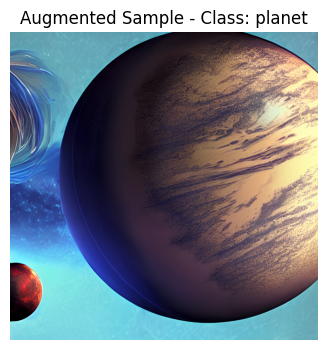

In [35]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]

plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Augmented Sample - Class: {label}")
plt.axis("off")
plt.show()


In [41]:
from PIL import Image, UnidentifiedImageError

class AugmentedTrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, minority_classes, transform_minority, transform_basic):
        self.df = df[df["split"] == "train"].reset_index(drop=True)
        self.minority_classes = minority_classes
        self.transform_minority = transform_minority
        self.transform_basic = transform_basic

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        while True:
            try:
                row = self.df.iloc[idx]
                img = Image.open(row["image_path"]).convert("RGB")

                if row["class"] in self.minority_classes:
                    img = self.transform_minority(img)
                else:
                    img = self.transform_basic(img)

                return img, row["class"]

            except (UnidentifiedImageError, OSError):
                idx = (idx + 1) % len(self.df)


In [42]:
from torchvision import transforms

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

basic_transform = transforms.ToTensor()


In [43]:
from PIL import Image

minority_classes = ["asteroid", "comet", "black hole"]

def load_image(path, label):
    img = Image.open(path).convert("RGB")
    
    if label in minority_classes:
        return augment_transform(img)
    else:
        return basic_transform(img)


In [44]:
row = df_splits[df_splits["split"] == "train"].iloc[0]

img = load_image(row["image_path"], row["class"])
img.shape


torch.Size([3, 2048, 2048])

The augmented training images are successfully loaded as tensors with shape
[3, 2048, 2048], confirming correct preprocessing and compatibility with
deep learning models.
